In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch as t

if os.path.join(*[i for i in os.getcwd().split(os.sep)[-1:]]) == 'notebooks':
    os.chdir("../")
print(os.getcwd())

/home/local/USHERBROOKE/aara2601/pycharmProjects/ALDy


# Loading Traffic Model

In [2]:
from summary.aldy_quickSummary import ALDy_QuickSummary as Summary

ts_dataset_name = 'traffic'

summary = Summary(ts_dataset_name)

In [3]:
aldy_experiments_path = "storage/experiments/aldy_exps"

traffic_aldy_experiments_path = os.path.join(aldy_experiments_path, ts_dataset_name)

experiment = "repeat=0,train_mode=AE_Temp_pbbilist,batch_size=1,f_input_window=32,encoder_dims=[256,128,64],non_overlap_batch=12,augV_method=noise,mask_mode=binomial,type_augV_latent=mean,pbbilist_modeling=True"

experiment_path = os.path.join(traffic_aldy_experiments_path, experiment)

summary.reset()
summary.load_experiment(experiment_path, other_losses=[])
summary.evaluate()
summary.summarize()

,EXPERIMENT_NAME,DATASET_NAME,EPOCH,HORIZON,TRAINING_LOSS,TESTING_LOSS
0,"repeat=0,train_mode=AE_Temp_pbbilist,batch_siz...",traffic,500,24,1.3,0.0


In [4]:
from models.aldy.aldy_ae_temp_pbbilist import ALDy
import numpy as np
import torch as t
from common.sampler_all_noisy import TimeSeriesSampler
from common.settings import DATASETS_PATH
from common.torch.ops import torch_dtype_dict
from common.torch.snapshots import SnapshotManager

used_dtype = eval(summary.config_dict["used_dtype"])

t.manual_seed(summary.config_dict["random_state"])
t.set_default_dtype(torch_dtype_dict[used_dtype])


dataset_path = os.path.join(DATASETS_PATH, ts_dataset_name, ts_dataset_name + '.npy')
ts_samples = np.load(dataset_path).transpose()  # ts_samples of shape (T, N)
ts_samples = ts_samples.astype(np.dtype(used_dtype))

f_input_window = eval(summary.config_dict["f_input_window"])
train_window = 2 * f_input_window

encoder_dims = eval(summary.config_dict["encoder_dims"])
ae_hidden_dims = list(encoder_dims)
encoder_dims.reverse()
ae_hidden_dims += encoder_dims

input_dim = ts_samples.shape[-1]
idx_hidden_dim = np.where(np.array([i if ae_hidden_dims[i] == ae_hidden_dims[i + 1] else 0
                                    for i in range(len(ae_hidden_dims) - 1)]) != 0)[0][0]
latent_dim = ae_hidden_dims[idx_hidden_dim]

f_model_params = {'model_type': eval(summary.config_dict["f_model_type"]),
                  'input_size': latent_dim,
                  'output_size': latent_dim,
                  'hidden_size': eval(summary.config_dict["f_hidden_size"]),
                  'num_layers': eval(summary.config_dict["f_num_layers"]),
                  'dropout': eval(summary.config_dict["f_dropout"]),
                  'batch_first': True}

n_val_windows = eval(summary.config_dict["n_val_windows"])
n_test_windows = eval(summary.config_dict["n_test_windows"])
horizon = eval(summary.config_dict["horizon"])


train_end_time_point = ts_samples.shape[0] - (
        n_val_windows + n_test_windows) * horizon - train_window
train_ts_std = np.nanstd(ts_samples[:train_end_time_point + train_window], axis=0)

used_mask = np.where(train_ts_std != 0)[0]
ts_samples = ts_samples[:, used_mask]
print("ts_samples.shape =", ts_samples.shape)

ts_sampler = TimeSeriesSampler(timeseries=ts_samples,
                                       train_window=train_window,
                                       f_input_window=f_input_window,
                                       horizon=horizon,
                                       non_overlap_batch=eval(summary.config_dict["non_overlap_batch"]),
                                       n_test_windows=n_test_windows,
                                       n_val_windows=n_val_windows,
                                       skip_end_n_val=(ts_dataset_name == 'electricity' and skip_end_n_val),
                                       noise_level=None)

ts_samples.shape = (10560, 963)


In [5]:
model = ALDy(input_dim=input_dim,
             ae_hidden_dims=ae_hidden_dims,
             f_model_params=f_model_params,
             mask_mode=eval(summary.config_dict["mask_mode"]),
             f_input_window=f_input_window,
             train_window=train_window,
             ts2vec_output_dims=None,
             ts2vec_hidden_dims=None,
             ts2vec_depth=None,
             ts2vec_mask_mode=None,
             dropout=0,
             activation=eval(summary.config_dict["activation"]),
             type_augV_latent=eval(summary.config_dict["type_augV_latent"]),
             direct_decoding=False,
             augV_method=eval(summary.config_dict["augV_method"]), ).to()

snapshot_manager = SnapshotManager(
            snapshot_dir=os.path.join(experiment_path, 'snapshots'),
            losses=['training', 'testing'],
            other_losses=[],
        )

epoch = snapshot_manager.restore(model, None)
epoch

Model of path "storage/experiments/aldy_exps/traffic/repeat=0,train_mode=AE_Temp_pbbilist,batch_size=1,f_input_window=32,encoder_dims=[256,128,64],non_overlap_batch=12,augV_method=noise,mask_mode=binomial,type_augV_latent=mean,pbbilist_modeling=True/snapshots/model" restored successfully


1000

In [6]:
eval(summary.config_dict["num_samples"])

1000

In [36]:
from common.torch.ops import to_tensor, default_device
from common.torch.losses import __loss_fn
from common.torch import CRPS

device = default_device()
mse_forecasting_loss_fn = __loss_fn('MSE')
num_samples = eval(summary.config_dict["num_samples"])

model = model.to(device)

input_windows_test, labels_test, input_windows_val = map(to_tensor,
                                                         ts_sampler.test_forecasting_windows(),
                                                         (device,) * 3)

# Normalize input windows
input_windows_test_normalized = (input_windows_test - to_tensor(ts_sampler.train_ts_means, device=device)) / to_tensor(ts_sampler.train_ts_std, device=device)

labels_test_normalized = (labels_test - to_tensor(ts_sampler.train_ts_means, device=device)) / to_tensor(ts_sampler.train_ts_std, device=device)


In [8]:
labels_test_normalized.shape, input_windows_test_normalized.shape

(torch.Size([7, 24, 963]), torch.Size([7, 32, 963]))

In [103]:
model.eval()
with t.no_grad():

    # Forecast future values
    y_forecast_samples_norm, y_forecast_mu_norm = model.rolling_forecast(y=input_windows_test_normalized,
                                                                         horizon=horizon,
                                                                         num_samples=num_samples,
                                                                         sigma=1)
    
    y_forecast_samples = y_forecast_samples_norm * to_tensor(ts_sampler.train_ts_std, device=device) + to_tensor(ts_sampler.train_ts_means, device=device)
    
    y_forecast_mu = y_forecast_mu_norm * to_tensor(ts_sampler.train_ts_std, device=device) + to_tensor(ts_sampler.train_ts_means, device=device)

In [104]:
with t.no_grad():

    # Forecast future values
    x_forecast_samples, x_forecast_mu = model.latent_rolling_forecast(y=input_windows_test_normalized,
                                                                     horizon=horizon,
                                                                     num_samples=num_samples,
                                                                     sigma=1)
    x_labels_test = model.encode(y=labels_test_normalized)

In [111]:
print(x_forecast_samples.shape, x_labels_test.shape, x_forecast_mu.shape)
print(y_forecast_samples.shape, y_forecast_mu.shape, labels_test.shape)

torch.Size([7, 24, 1000, 64]) torch.Size([7, 24, 64]) torch.Size([7, 24, 64])
torch.Size([7, 24, 1000, 963]) torch.Size([7, 24, 963]) torch.Size([7, 24, 963])


In [114]:
x_samples, x_target, x_mu = x_forecast_samples.reshape(n_test_windows * horizon, num_samples, latent_dim), x_labels_test.reshape(n_test_windows * horizon, latent_dim), x_forecast_mu.reshape(n_test_windows * horizon, latent_dim)
y_samples, y_target, y_mu = y_forecast_samples.reshape(n_test_windows * horizon, num_samples, input_dim), labels_test.reshape(n_test_windows * horizon, input_dim), y_forecast_mu.reshape(n_test_windows * horizon, input_dim)

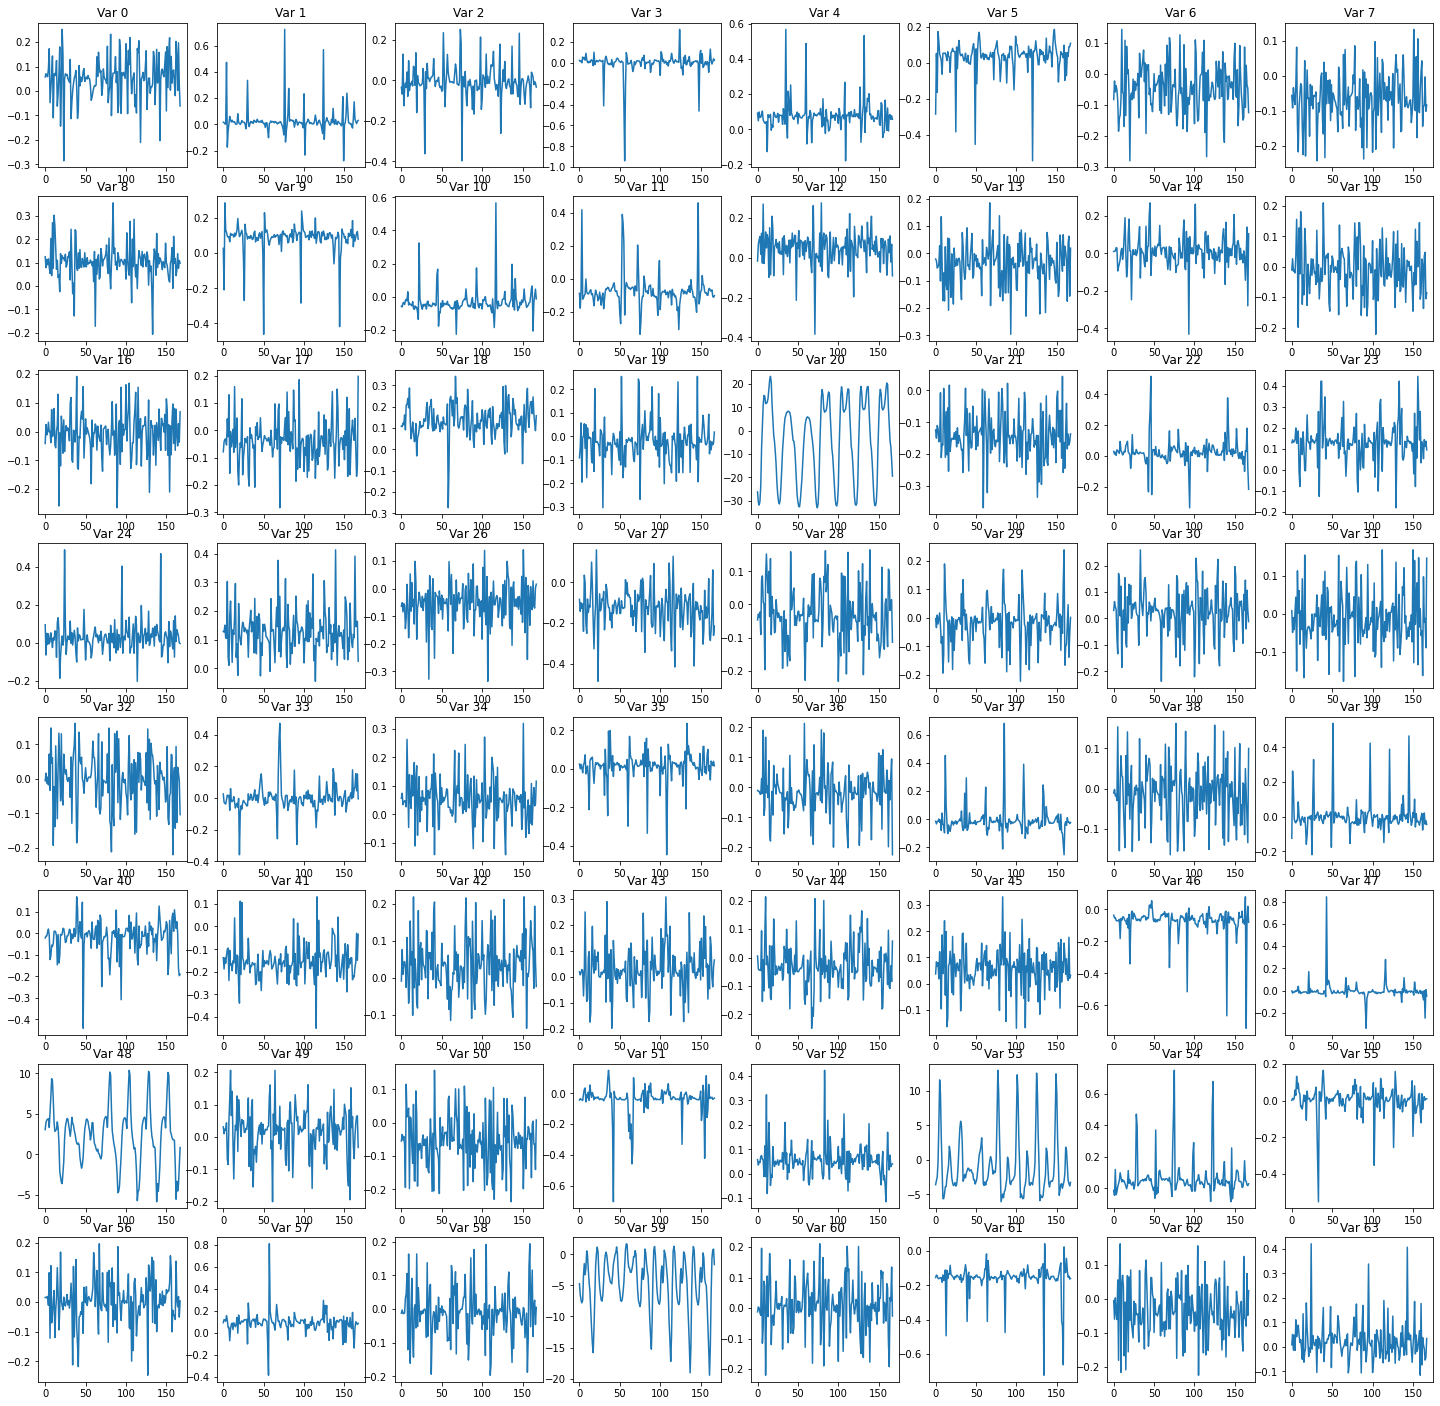

In [107]:
fig, axs = plt.subplots(8, 8, figsize=(25, 25))
for k in range(64):
    i, j = k // 8,  k % 8
    axs[i, j].plot(x_target[:, k].detach().cpu().numpy())
    axs[i, j].set_title('Var ' + str(k))

In [240]:
# selected_latent_vars = [1, 2, 20, 22, 48, 53, 59, 61]
# selected_latent_vars = [1, 33, 20, 37, 48, 53, 59, 47]
# selected_latent_vars = [1, 33, 20, 37, 48, 53, 59, 9]
selected_latent_vars = [1, 61, 20, 37, 48, 53, 59, 9]

# selected_real_vars = [251, 262, 104, 819, 306, 716, 114, 620]

# selected_real_vars = [321, 107, 907, 943, 38, 707, 772, 543]
selected_real_vars = [875, 545, 886, 3, 74, 159, 328, 139]
# [104, 473, 212, 280, 651, 709, 446, 722]

# import random
# selected_real_vars = random.choices(np.arange(input_dim), k=8)
# print(selected_real_vars)

x_samples_selected, x_target_selected, x_mu_selected = x_samples[:,:,selected_latent_vars], x_target[:,selected_latent_vars], x_mu[:,selected_latent_vars]
y_samples_selected, y_target_selected, y_mu_selected = y_samples[:,:,selected_real_vars], y_target[:,selected_real_vars], y_mu[:,selected_real_vars]

# Ploting Samples forecast vs labels

### Ploting Samples forecast vs labels for Latent Vars

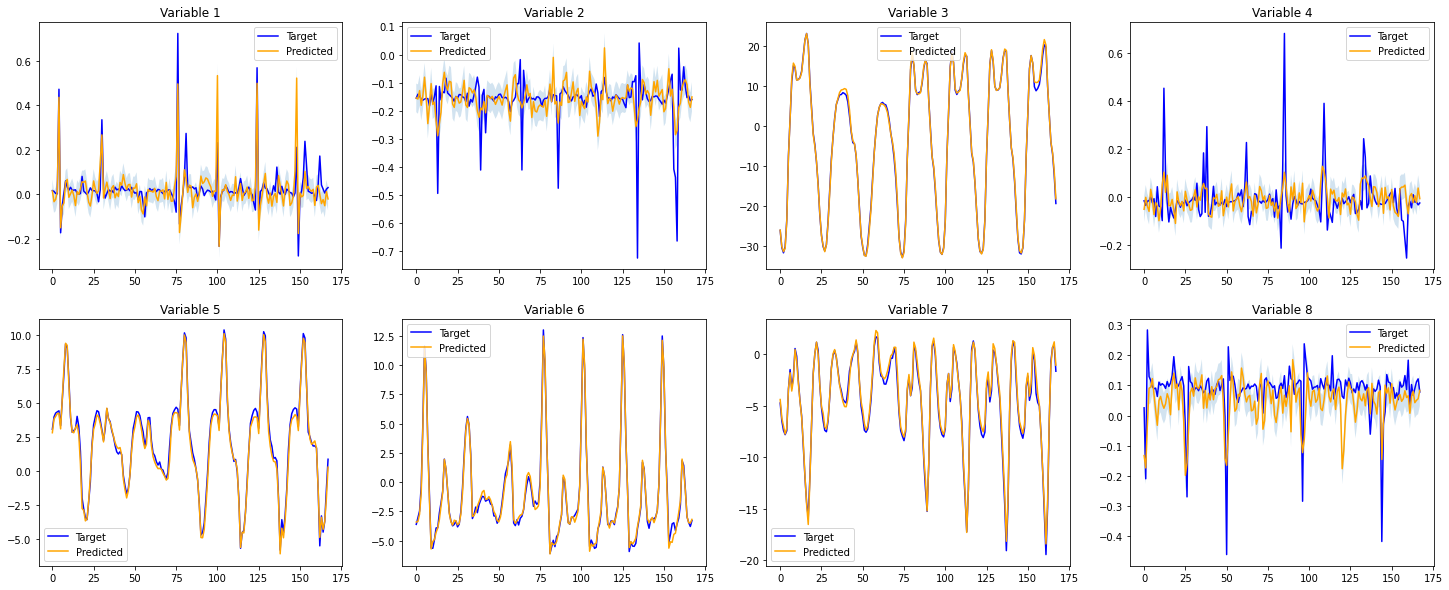

In [241]:
# Calculate the mean and standard deviation of the predicted samples for each variable
mean_samples = x_samples_selected.mean(dim=1)  # shape: [168, 8]
std_samples = x_samples_selected.std(dim=1)  # shape: [168, 8]

# Calculate the upper and lower bounds of the 90% confidence interval for each variable
lower_bound = mean_samples - 1.645 * std_samples / (1000 ** 0.5)
upper_bound = mean_samples + 1.645 * std_samples / (1000 ** 0.5)

# Create subplots for each variable
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
axs = axs.ravel()

# Plot each variable on a separate subplot
for i in range(8):
    # Plot the actual values as a blue line
    axs[i].plot(x_target_selected[:, i].detach().cpu().numpy(), color='blue', label='Target')
    # Plot the mean predicted values as an orange line
    axs[i].plot(mean_samples[:, i].detach().cpu().numpy(), color='orange', label='Predicted')
    # Shade the area between the upper and lower bounds of the confidence interval
    axs[i].fill_between(range(168), lower_bound[:, i].detach().cpu().numpy(), upper_bound[:, i].detach().cpu().numpy(), alpha=0.2)
    # Set the axis labels and title
    axs[i].set_title(f'Variable {i + 1}')
    # Add a legend
    axs[i].legend()

# Show the plot
plt.show()

### Ploting Samples forecast vs labels for Real Vars

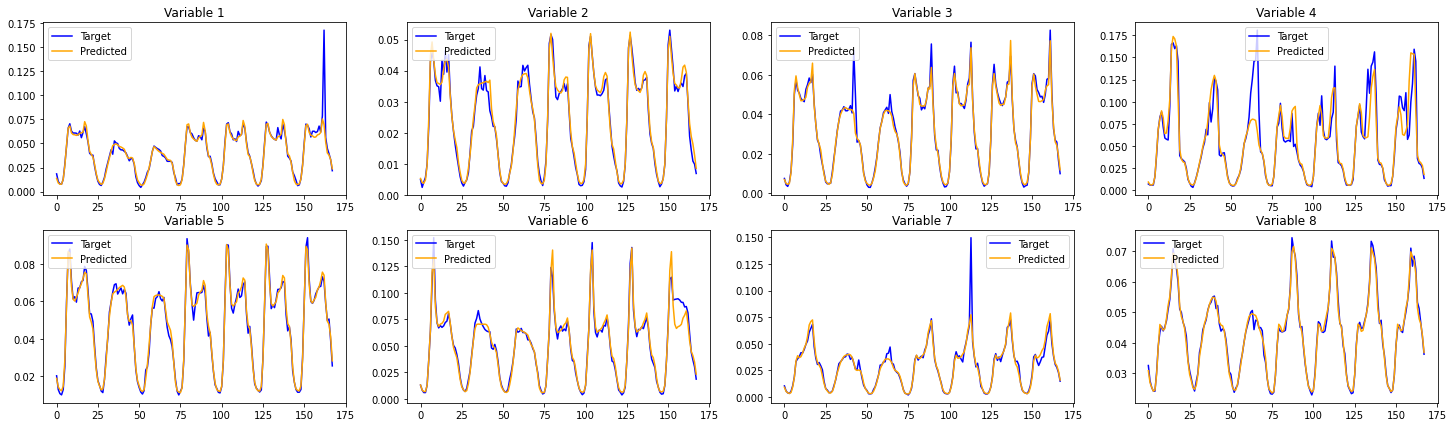

In [229]:
# Calculate the mean and standard deviation of the predicted samples for each variable
mean_samples = y_samples_selected.mean(dim=1)  # shape: [168, 8]
std_samples = y_samples_selected.std(dim=1)  # shape: [168, 8]

# Calculate the upper and lower bounds of the 90% confidence interval for each variable
lower_bound = mean_samples - 1.645 * std_samples / (1000 ** 0.5)
upper_bound = mean_samples + 1.645 * std_samples / (1000 ** 0.5)

# Create subplots for each variable
fig, axs = plt.subplots(2, 4, figsize=(25, 7))
axs = axs.ravel()

# Plot each variable on a separate subplot
for i in range(8):
    # Plot the actual values as a blue line
    axs[i].plot(y_target_selected[:, i].detach().cpu().numpy(), color='blue', label='Target')
    # Plot the mean predicted values as an orange line
    axs[i].plot(mean_samples[:, i].detach().cpu().numpy(), color='orange', label='Predicted')
    # Shade the area between the upper and lower bounds of the confidence interval
    axs[i].fill_between(range(168), lower_bound[:, i].detach().cpu().numpy(), upper_bound[:, i].detach().cpu().numpy(), alpha=0.2)
    # Set the axis labels and title
    axs[i].set_title(f'Variable {i + 1}')
    # Add a legend
    axs[i].legend()

# Show the plot
plt.show()

# Ploting curves using lambda_BT vs not using it

                                     EXPERIMENT_NAME DATASET_NAME  EPOCH  \
0  repeat=0,train_mode=AE_Temp,batch_size=1,f_inp...      traffic    629   

  HORIZON  TRAINING_LOSS  TESTING_LOSS  MAPE_LOSS  WAPE_LOSS  SMAPE_LOSS  
0      24          16.54         0.012      0.112      0.099       0.086  


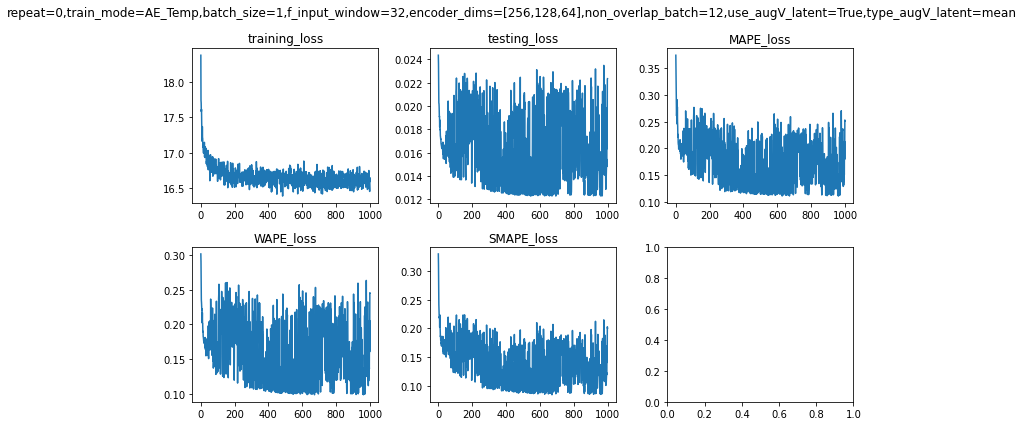

In [248]:
aldy_experiments_path = "storage/experiments/aldy_exps"

traffic_aldy_experiments_path = os.path.join(aldy_experiments_path, ts_dataset_name)

experiment_path = os.path.join(traffic_aldy_experiments_path, "repeat=0,train_mode=AE_Temp,batch_size=1,f_input_window=32,encoder_dims=[256,128,64],non_overlap_batch=12,use_augV_latent=True,type_augV_latent=mean")
summary.reset()
summary.load_experiment(experiment_path)
summary.evaluate()
print(summary.summarize())
summary.plot_loss_curves()

                                     EXPERIMENT_NAME DATASET_NAME  EPOCH  \
0  repeat=0,train_mode=AE_Temp,batch_size=1,f_inp...      traffic    718   

  HORIZON  TRAINING_LOSS  TESTING_LOSS  MAPE_LOSS  WAPE_LOSS  SMAPE_LOSS  
0      24          0.114         0.012      0.111      0.098       0.086  


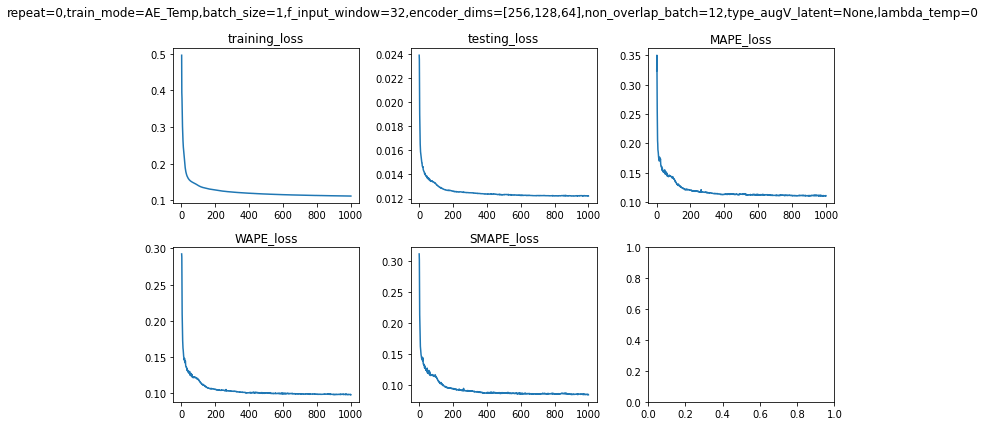

In [247]:
aldy_experiments_path = "storage/experiments/aldy_exps"

traffic_aldy_experiments_path = os.path.join(aldy_experiments_path, ts_dataset_name)

experiment_path = os.path.join(traffic_aldy_experiments_path, "repeat=0,train_mode=AE_Temp,batch_size=1,f_input_window=32,encoder_dims=[256,128,64],non_overlap_batch=12,type_augV_latent=None,lambda_temp=0")
summary.reset()
summary.load_experiment(experiment_path)
summary.evaluate()
print(summary.summarize())
summary.plot_loss_curves()